# 2-4_ResNet

This notebook provides a PyTorch implementation of *Deep Residual Learning for Image Recogniton* by Kaiming He, Xiangyu Zhang, Shaoqing Ren, and Han Sun which achived state of the art in 2015 by winning the ILSVRC and COCO challenges.

In [3]:
%matplotlib inline

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm.autonotebook import tqdm
from torchvision import transforms
from torchvision import datasets

import torchvision
import torchvision.transforms as transforms


from torch.utils.data.sampler import SubsetRandomSampler
import warnings
warnings.filterwarnings('ignore')

# 1. Basic ResNet block

Follow the below diagram and implement the `forward()` method of the class `block`.

The computation graph should be constructed as `((conv->bn->relu->conv->bn)+shortcut)->relu`

![a](https://miro.medium.com/max/472/1*Cc3o7Hq7aMb0JPb9UuuxzA.png)

In [5]:
class block(nn.Module):
    def __init__(self, filters, subsample=False):
        super().__init__()
        """
        A 2-layer residual learning building block as illustrated by Fig.2
        in "Deep Residual Learning for Image Recognition"
        
        Parameters:
        
        - filters:   int
                     the number of filters for all layers in this block
                   
        - subsample: boolean
                     whether to subsample the input feature maps with stride 2
                     and doubling in number of filters
                     
        Attributes:
        
        - shortcuts: boolean
                     When false the residual shortcut is removed
                     resulting in a 'plain' convolutional block.
        """
        # Determine subsampling
        s = 0.5 if subsample else 1.0
        
        # Setup layers
        self.conv1 = nn.Conv2d(int(filters*s), filters, kernel_size=3, 
                               stride=int(1/s), padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(filters, track_running_stats=True)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(filters, filters, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(filters, track_running_stats=True)
        self.relu2 = nn.ReLU()

        # Shortcut downsampling
        self.downsample = nn.AvgPool2d(kernel_size=1, stride=2)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)   
        
    def shortcut(self, z, x):
        """ 
        Implements parameter free shortcut connection by identity mapping.
        If dimensions of input x are greater than activations then this
        is rectified by downsampling and then zero padding dimension 1
        as described by option A in paper.
        
        Parameters:
        - x: tensor
             the input to the block
        - z: tensor
             activations of block prior to final non-linearity
        """
        if x.shape != z.shape:
            d = self.downsample(x)
            p = torch.mul(d, 0)
            return z + torch.cat((d, p), dim=1)
        else:
            return z + x        
    
    def forward(self, x, shortcuts=False):
        z = self.conv1(x)
        z = self.bn1(z)
        z = self.relu1(z)
        
        z = self.conv2(z)
        z = self.bn2(z)
        
        if shortcuts:
            z = self.shortcut(z, x)

        z = self.relu2(z)
        
        return z

# 2. ResNet Architecture

In [6]:
class ResNet(nn.Module):
    def __init__(self, n, shortcuts=True):
        super().__init__()
        self.shortcuts = shortcuts
        
        # Input
        self.convIn = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bnIn   = nn.BatchNorm2d(16, track_running_stats=True)
        self.relu   = nn.ReLU()
        
        # Stack1
        self.stack1 = nn.ModuleList([block(16, subsample=False) for _ in range(n)])

        # Stack2
        self.stack2a = block(32, subsample=True)
        self.stack2b = nn.ModuleList([block(32, subsample=False) for _ in range(n-1)])

        # Stack3
        self.stack3a = block(64, subsample=True)
        self.stack3b = nn.ModuleList([block(64, subsample=False) for _ in range(n-1)])
        
        # Output
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fcOut   = nn.Linear(64, 10, bias=True)
        self.softmax = nn.LogSoftmax(dim=-1)
        
        # Initialize weights in fully connected layer 
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal(m.weight)
                m.bias.data.zero_()      
        
        
    def forward(self, x):
        z = self.convIn(x)
        z = self.bnIn(z)
        z = self.relu(z)
        
        for l in self.stack1:
            z = l(z, shortcuts=self.shortcuts)
        
        z = self.stack2a(z, shortcuts=self.shortcuts)
        for l in self.stack2b: 
            z = l(z, shortcuts=self.shortcuts)
        
        z = self.stack3a(z, shortcuts=self.shortcuts)
        for l in self.stack3b: 
            z = l(z, shortcuts=self.shortcuts)

        z = self.avgpool(z)
        z = z.view(z.size(0), -1)
        z = self.fcOut(z)
        return self.softmax(z)

# 3. Evaluation Function

In [7]:
import pandas as pd
import torch

def evaluate(model, data_loader, device):
    """
    Calculate classification error (%) for given model
    and data set.
    
    Parameters:
    
    - model: A Trained Pytorch Model 
    - data_loader: A Pytorch data loader object
    """
    
    y_true = np.array([], dtype=np.int)
    y_pred = np.array([], dtype=np.int)
    
    with torch.no_grad():
        for data in data_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            
            y_true = np.concatenate((y_true, labels.cpu()))
            y_pred = np.concatenate((y_pred, predicted.cpu()))
    
    error = np.sum(y_pred != y_true) / len(y_true)
    return error

# 4. Training Loop

In [8]:
def train(model, epochs, train_loader, test_loader, criterion, 
          optimizer, RESULTS_PATH, scheduler=None, MODEL_PATH=None):
    # Run on GPU if available
    device = torch.device("cuda")
    print(device)
    model.to(device)
    
    # Training loop
    # -------------------------------
    cols       = ['epoch', 'train_loss', 'train_err', 'test_err']
    results_df = pd.DataFrame(columns=cols).set_index('epoch')
    print('Epoch \tBatch \tNLLLoss_Train')
    
    for epoch in range(epochs):  # loop over the dataset multiple times
        
        model.train()
        running_loss  = 0.0
        best_test_err = 1.0
        for i, data in enumerate(train_loader, 0):   # Do a batch iteration
            
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # print average loss for last 50 mini-batches
            running_loss += loss.item()
            if i % 50 == 49:
                print('%d \t%d \t%.3f' %
                      (epoch + 1, i + 1, running_loss / 50))
                running_loss = 0.0
        
        if scheduler:
            scheduler.step()
        
        # Record metrics
        model.eval()
        train_loss = loss.item()
        train_err = evaluate(model, train_loader, device)
        test_err = evaluate(model, test_loader, device)
        results_df.loc[epoch] = [train_loss, train_err, test_err]
        results_df.to_csv(RESULTS_PATH)
        print(f'train_err: {train_err} test_err: {test_err}')
        
        # Save best model
        if MODEL_PATH and (test_err < best_test_err):
            torch.save(model.state_dict(), MODEL_PATH)
            best_test_err = test_err
        
        
    
    print('Finished Training')
    model.eval()
    return model

In [9]:
train_data = torchvision.datasets.CIFAR10(root='data', train=True, download=True)

means = train_data.data.mean(axis = (0,1,2)) / 255
stds = train_data.data.std(axis = (0,1,2)) / 255

print('Calculated means: {}'.format(means))
print('Calculated stds: {}'.format(stds))

Files already downloaded and verified
Calculated means: [0.49139968 0.48215841 0.44653091]
Calculated stds: [0.24703223 0.24348513 0.26158784]


In [10]:
transform_train = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=means, std=means),
     transforms.RandomHorizontalFlip(),])
transform_test = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])


cifar10_train = torchvision.datasets.CIFAR10(root='data', train=True, transform=transform_train, download=True)
cifar10_test = torchvision.datasets.CIFAR10(root='data', train=False, transform=transform_test, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [11]:
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import RandomSampler
from torch.utils.tensorboard import SummaryWriter
from tqdm.autonotebook import tqdm
import time

In [14]:
device = 'cuda'
train_batch = 100
test_batch = 200
n_epochs = 15
num_workers = 4
lr = 0.01
momentum = 0.9
log_dir = 'log/cifar10/resnet'

model = ResNet(9, shortcuts=True)

train_loader = DataLoader(
    cifar10_train, train_batch, sampler=RandomSampler(cifar10_train),
    num_workers=num_workers)
test_loader = DataLoader(
    cifar10_test, test_batch, num_workers=num_workers)
n_minibatches = len(train_loader)

# it combines softmax with negative log likelihood loss
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

# Move model to gpu if possible
model = model.to(device)

training_start_time = time.time()
writer = SummaryWriter(log_dir)
step = 0

for epoch in range(1, n_epochs+1): # loop over the dataset multiple times
    
    write_period = n_minibatches // 100
    start_time = time.time()
    train_loss = 0
    
    for x, y in tqdm(train_loader):
        # Move tensors to correct device
        x, y = x.to(device), y.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.detach()
        
        step += 1
        # Summary
        if step % write_period == 0:
            writer.add_scalar('loss/train', loss.detach(), step)

    # Eval
    total, correct = 0, 0
    test_loss = 0
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)

        # Don't compute gradient during evaluation
        with torch.no_grad():
            pred = model(x)

        test_loss += criterion(pred, y) * x.shape[0]

        total += x.shape[0]
        correct += (pred.max(dim=1)[1] == y).sum()

    test_loss /= total
    accuracy = correct / total

    writer.add_scalar('loss/test', test_loss, step)
    writer.add_scalar('accuracy', accuracy, step)
    
    print("Epoch {} in {:.2f}s, train_loss={:.2f}, test_loss={:.2f}, test_accuracy={:.2f}".
          format(epoch, time.time() - start_time, train_loss / n_minibatches,
                test_loss, accuracy))

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1 in 18.82s, train_loss=1.62, test_loss=1.33, test_accuracy=0.51


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2 in 18.86s, train_loss=1.18, test_loss=1.03, test_accuracy=0.63


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3 in 18.88s, train_loss=0.95, test_loss=0.89, test_accuracy=0.69


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4 in 18.89s, train_loss=0.80, test_loss=0.78, test_accuracy=0.73


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5 in 18.90s, train_loss=0.70, test_loss=0.72, test_accuracy=0.75


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 6 in 19.04s, train_loss=0.62, test_loss=0.67, test_accuracy=0.77


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 7 in 19.01s, train_loss=0.56, test_loss=0.68, test_accuracy=0.77


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 8 in 18.98s, train_loss=0.50, test_loss=0.64, test_accuracy=0.78


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 9 in 18.99s, train_loss=0.47, test_loss=0.60, test_accuracy=0.80


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 10 in 18.95s, train_loss=0.43, test_loss=0.60, test_accuracy=0.79


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 11 in 19.08s, train_loss=0.39, test_loss=0.56, test_accuracy=0.81


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 12 in 19.00s, train_loss=0.37, test_loss=0.57, test_accuracy=0.81


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 13 in 19.01s, train_loss=0.34, test_loss=0.59, test_accuracy=0.81


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 14 in 19.01s, train_loss=0.31, test_loss=0.59, test_accuracy=0.81


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 15 in 19.12s, train_loss=0.28, test_loss=0.59, test_accuracy=0.81


In [17]:
lr = 0.1 # authors cite 0.1
momentum = 0.9
weight_decay = 0.0001 
milestones = [82, 123]
gamma = 0.1

device = 'cuda'
train_batch = 100
test_batch = 200
n_epochs = 15
num_workers = 4
lr = 0.01
momentum = 0.9
log_dir = 'log/cifar10/resnet'

train_loader = DataLoader(
    cifar10_train, train_batch, sampler=RandomSampler(cifar10_train),
    num_workers=num_workers)
test_loader = DataLoader(
    cifar10_test, test_batch, num_workers=num_workers)
n_minibatches = len(train_loader)

model = ResNet(3, shortcuts=True)
criterion = torch.nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
# scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

# Move model to gpu if possible
model = model.to(device)

training_start_time = time.time()
writer = SummaryWriter(log_dir)
step = 0

for epoch in range(1, n_epochs+1): # loop over the dataset multiple times
    
    write_period = n_minibatches // 100
    start_time = time.time()
    train_loss = 0
    
    for x, y in tqdm(train_loader):
        # Move tensors to correct device
        x, y = x.to(device), y.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.detach()
        
        step += 1
        # Summary
        if step % write_period == 0:
            writer.add_scalar('loss/train', loss.detach(), step)

    # Eval
    total, correct = 0, 0
    test_loss = 0
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)

        # Don't compute gradient during evaluation
        with torch.no_grad():
            pred = model(x)

        test_loss += criterion(pred, y) * x.shape[0]

        total += x.shape[0]
        correct += (pred.max(dim=1)[1] == y).sum()

    test_loss /= total
    accuracy = correct / total

    writer.add_scalar('loss/test', test_loss, step)
    writer.add_scalar('accuracy', accuracy, step)
    
    print("Epoch {} in {:.2f}s, train_loss={:.2f}, test_loss={:.2f}, test_accuracy={:.2f}".
          format(epoch, time.time() - start_time, train_loss / n_minibatches,
                test_loss, accuracy))

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 1 in 8.05s, train_loss=1.49, test_loss=1.20, test_accuracy=0.56


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2 in 7.95s, train_loss=1.09, test_loss=1.00, test_accuracy=0.64


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3 in 8.02s, train_loss=0.92, test_loss=0.91, test_accuracy=0.68


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4 in 8.07s, train_loss=0.81, test_loss=0.79, test_accuracy=0.73


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5 in 8.04s, train_loss=0.72, test_loss=0.74, test_accuracy=0.74


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 6 in 8.00s, train_loss=0.66, test_loss=0.68, test_accuracy=0.76


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 7 in 8.08s, train_loss=0.60, test_loss=0.67, test_accuracy=0.77


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 8 in 7.99s, train_loss=0.56, test_loss=0.61, test_accuracy=0.79


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 9 in 8.19s, train_loss=0.53, test_loss=0.61, test_accuracy=0.79


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 10 in 7.90s, train_loss=0.49, test_loss=0.60, test_accuracy=0.79


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 11 in 8.04s, train_loss=0.46, test_loss=0.57, test_accuracy=0.81


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 12 in 8.07s, train_loss=0.44, test_loss=0.57, test_accuracy=0.80


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 13 in 7.85s, train_loss=0.42, test_loss=0.56, test_accuracy=0.81


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 14 in 7.95s, train_loss=0.40, test_loss=0.58, test_accuracy=0.80


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 15 in 8.03s, train_loss=0.38, test_loss=0.55, test_accuracy=0.81


### A. Data Sanity Check

In [10]:
from torch.utils.data.sampler import SubsetRandomSampler


def get_data_loaders(data_dir,
                     batch_size,
                     train_transform,
                     test_transform,
                     shuffle=True,
                     num_workers=4,
                     pin_memory=False):
    # Load the datasets
    train_dataset = datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    test_dataset = datasets.CIFAR10(
        root=data_dir, train=False,
        download=True, transform=test_transform,
    )
    # Create loader objects
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers, pin_memory=pin_memory
    )
    return (train_loader, test_loader)

In [11]:
def plot_images(images, cls_true, cls_pred=None):
    # CIFAR10 labels
    label_names = [
        'airplane',
        'automobile',
        'bird',
        'cat',
        'deer',
        'dog',
        'frog',
        'horse',
        'ship',
        'truck'
    ]
    fig, axes = plt.subplots(3, 3)
    for i, ax in enumerate(axes.flat):
        # plot img
        ax.imshow(images[i, :, :, :], interpolation='spline16')
        # show true & predicted classes
        cls_true_name = label_names[cls_true[i]]
        if cls_pred is None:
            xlabel = "{0} ({1})".format(cls_true_name, cls_true[i])
        else:
            cls_pred_name = label_names[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(
                cls_true_name, cls_pred_name
            )
        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()


In [12]:
# Load data without normalizations
train_transform = transforms.Compose([
    # 4 pixels are padded on each side, 
    transforms.Pad(4),
    # a 32×32 crop is randomly sampled from the 
    # padded image or its horizontal flip.
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    # For testing, we only evaluate the single 
    # view of the original 32×32 image.
    transforms.ToTensor()
])

train_loader, test_loader = get_data_loaders('data',
                                             128,
                                             train_transform,
                                             test_transform,
                                             shuffle=True,
                                             num_workers=4,
                                             pin_memory=True)

Files already downloaded and verified
Files already downloaded and verified


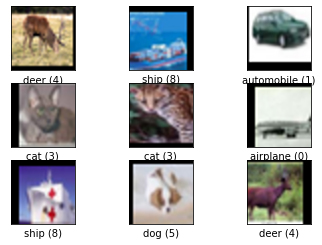

torch.Size([128, 3, 32, 32])


In [13]:
# Training images
data_iter = iter(train_loader)
images, labels = data_iter.next()
X = images.numpy().transpose([0, 2, 3, 1])
plot_images(X, labels)
print(images.shape)

The training set consists of 50,000 32x32 pixel images. These are padded with 4 pixels on each side, before a crop is randomly sampled from the padded image or its horziontal flip. 

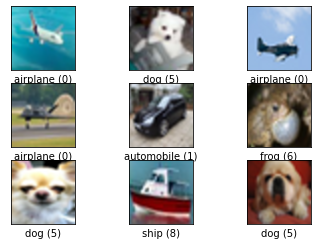

torch.Size([128, 3, 32, 32])


In [14]:
# Test images
data_iter = iter(test_loader)
images, labels = data_iter.next()
X = images.numpy().transpose([0, 2, 3, 1])
plot_images(X, labels)
print(images.shape)

There are 10,000 images in the test set. These are not transformed.

### B. Calculate normalization parameters

In [19]:
# NORMALIZATION
# -----------------------
# Calculate the mean and standard deviation of each channel
# for all observations in training and test datasets. The
# results can then be used for normalization

def calculate_normalization_params(train_loader, test_loader):
    chan0 = np.array([])
    chan1 = np.array([])
    chan2 = np.array([])
    
    for i, data in tqdm(enumerate(train_loader, 0)):
        images, _ = data
        chan0 = np.concatenate((chan0, images[:, 0, :, :].cpu().flatten()))
        chan1 = np.concatenate((chan0, images[:, 1, :, :].cpu().flatten()))
        chan2 = np.concatenate((chan0, images[:, 2, :, :].cpu().flatten()))
        
    for i, data in tqdm(enumerate(test_loader, 0)):
        images, _ = data
        chan0 = np.concatenate((chan0, images[:, 0, :, :].cpu().flatten()))
        chan1 = np.concatenate((chan0, images[:, 1, :, :].cpu().flatten()))
        chan2 = np.concatenate((chan0, images[:, 2, :, :].cpu().flatten()))
        
    means = [np.mean(chan0), np.mean(chan1), np.mean(chan2)]
    stds  = [np.std(chan0), np.std(chan1), np.std(chan2)]
    
    return means, stds


train_transform = transforms.Compose([transforms.ToTensor()])
test_transform = transforms.Compose([transforms.ToTensor()])
means, stds = calculate_normalization_params(*get_data_loaders('data/cifar10',
                                             512,
                                             train_transform,
                                             test_transform,
                                             shuffle=True,
                                             num_workers=4,
                                             pin_memory=True))
print(f'means: {means}')
print(f'stds: {stds}')

Files already downloaded and verified
Files already downloaded and verified


0it [00:00, ?it/s]

0it [00:00, ?it/s]

means: [0.4918687901200919, 0.4919023927066117, 0.49169329554524477]
stds: [0.24697121702736, 0.2469509598387053, 0.24704262939417207]


# 5. Construct the Data Augmentation Pipeline

Here we finalise data augmentation and normalization parameters ahead of training.

In [20]:
# SET FINAL TRANSFORMS WITH NORMALIZATION

# [x] simple data augmentation in [24]
# [x] 4 pixels are padded on each side, 
# [x] and a 32×32 crop is randomly sampled from the padded image or its horizontal flip.
# [x] For testing, we only evaluate the single view of the original 32×32 image.

normalize = transforms.Normalize(
    mean=means,
    std=stds,
)

train_transform = transforms.Compose([
    # 4 pixels are padded on each side, 
    transforms.Pad(4),
    # a 32×32 crop is randomly sampled from the 
    # padded image or its horizontal flip.
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    normalize
])

test_transform = transforms.Compose([
    # For testing, we only evaluate the single 
    # view of the original 32×32 image.
    transforms.ToTensor(),
    normalize
])

# 6. Hyperparameters

Set the hyperparameters as described by the authors, with iterations converted to epochs where appropriate.

In [21]:
# TRAINING PARAMETERS
# -------------------------

data_dir = 'data/cifar10'
batch_size = 128

# Authors cite 64k iterations
# 64000/391 = 164
epochs = 3

# OPTIMIZER PARAMETERS
lr = 0.1 # authors cite 0.1
momentum = 0.9
weight_decay = 0.0001 

# LEARNING RATE ADJUSTMENT
# Reduce learning rate at iterations 
# 32k and 48k. Convert to epochs:
# e.g. iterations / (n_observations/batch_size) 
# 32000/391 = 82
# 48000/391 = 123
milestones = [82, 123]
# Divide learning rate by 10 at each milestone
gamma = 0.1

# 7. Training the plain net

Run training loop for **'plain' convolutional networks** without shortcuts. Here we run for n={3, 5, 7,9} corresponding to networks of depth 20, 32, 44 and 64 layers. 

In [22]:
# TRAIN PLAIN NETs

# n determines network size as described in paper
# where total number of layers is (6*n)+2
ns = [3, 5, 7, 9]

# Train plainnets
for n in ns:
    print(f'MODEL SIZE: n={n}')
    # Reload data
    train_loader, test_loader = get_data_loaders(data_dir,
                                                 batch_size,
                                                 train_transform,
                                                 test_transform,
                                                 shuffle=True,
                                                 num_workers=4,
                                                 pin_memory=True)
    
    model = ResNet(n, shortcuts=False)
    criterion = torch.nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    results_file = f'plainnet{6*n+2}.csv'
    model_file = f'plainnet{6*n+2}.pt'
    train(model, epochs, train_loader, test_loader, criterion, 
          optimizer, results_file, scheduler=scheduler, MODEL_PATH=model_file)

MODEL SIZE: n=3
Files already downloaded and verified
Files already downloaded and verified
cuda
Epoch 	Batch 	NLLLoss_Train
1 	50 	2.087
1 	100 	1.835
1 	150 	1.741
1 	200 	1.705
1 	250 	1.656
1 	300 	1.638
1 	350 	1.600
train_err: 0.59672 test_err: 0.5786
2 	50 	1.548
2 	100 	1.497
2 	150 	1.466
2 	200 	1.436
2 	250 	1.390
2 	300 	1.357
2 	350 	1.319
train_err: 0.52474 test_err: 0.5145
3 	50 	1.243
3 	100 	1.208
3 	150 	1.151
3 	200 	1.146
3 	250 	1.114
3 	300 	1.105
3 	350 	1.046
train_err: 0.39856 test_err: 0.3983
Finished Training
MODEL SIZE: n=5
Files already downloaded and verified
Files already downloaded and verified
cuda
Epoch 	Batch 	NLLLoss_Train
1 	50 	2.329
1 	100 	2.137
1 	150 	1.979
1 	200 	1.910
1 	250 	1.861
1 	300 	1.836
1 	350 	1.814
train_err: 0.6585 test_err: 0.6437
2 	50 	1.770
2 	100 	1.746
2 	150 	1.710
2 	200 	1.709
2 	250 	1.678
2 	300 	1.663
2 	350 	1.646
train_err: 0.63046 test_err: 0.6141
3 	50 	1.580
3 	100 	1.558
3 	150 	1.570
3 	200 	1.548
3 	250 	1.507

# 8. Training the ResNet

Run training loop for residual networks with shortcuts. Here we run for n={3, 5, 7,9} corresponding to networks of depth 20, 32, 44 and 64 layers.


In [23]:
# TRAIN RESNETs

# n determines network size as described in paper
ns = [3, 5, 7, 9]

# Train resnets
for n in ns:
    print(f'MODEL SIZE: n={n}')
    # Reload data
    train_loader, test_loader = get_data_loaders(data_dir,
                                                 batch_size,
                                                 train_transform,
                                                 test_transform,
                                                 shuffle=True,
                                                 num_workers=4,
                                                 pin_memory=True)
    
    model = ResNet(n, shortcuts=True)
    criterion = torch.nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    results_file = f'resnet{6*n+2}.csv'
    model_file = f'resnet{6*n+2}.pt'
    train(model, epochs, train_loader, test_loader, criterion, 
          optimizer, results_file, scheduler=scheduler, MODEL_PATH=model_file)

MODEL SIZE: n=3
Files already downloaded and verified
Files already downloaded and verified
cuda
Epoch 	Batch 	NLLLoss_Train
1 	50 	2.191
1 	100 	1.766
1 	150 	1.670
1 	200 	1.568
1 	250 	1.499
1 	300 	1.448
1 	350 	1.344
train_err: 0.5532 test_err: 0.5696
2 	50 	1.265
2 	100 	1.216
2 	150 	1.163
2 	200 	1.115
2 	250 	1.093
2 	300 	1.067
2 	350 	1.033
train_err: 0.37482 test_err: 0.3675
3 	50 	0.972
3 	100 	0.970
3 	150 	0.943
3 	200 	0.911
3 	250 	0.882
3 	300 	0.875
3 	350 	0.830
train_err: 0.30396 test_err: 0.3036
Finished Training
MODEL SIZE: n=5
Files already downloaded and verified
Files already downloaded and verified
cuda
Epoch 	Batch 	NLLLoss_Train
1 	50 	2.543
1 	100 	1.931
1 	150 	1.800
1 	200 	1.720
1 	250 	1.637
1 	300 	1.552
1 	350 	1.502
train_err: 0.56344 test_err: 0.5435
2 	50 	1.411
2 	100 	1.316
2 	150 	1.283
2 	200 	1.218
2 	250 	1.190
2 	300 	1.106
2 	350 	1.098
train_err: 0.41384 test_err: 0.4231
3 	50 	1.006
3 	100 	1.008
3 	150 	0.975
3 	200 	0.934
3 	250 	0.904

In [27]:
# TRAIN RESNETs

# n determines network size as described in paper
ns = [3, 5, 7, 9]

# Train resnets
for n in ns:
    print(f'MODEL SIZE: n={n}')
    # Reload data
    train_loader, test_loader = get_data_loaders(data_dir,
                                                 batch_size,
                                                 train_transform,
                                                 test_transform,
                                                 shuffle=True,
                                                 num_workers=4,
                                                 pin_memory=True)
    
    model = ResNet(n, shortcuts=True)
    criterion = torch.nn.NLLLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)
    results_file = f'resnet{6*n+2}.csv'
    model_file = f'resnet{6*n+2}.pt'
    train(model, 20, train_loader, test_loader, criterion, 
          optimizer, results_file, scheduler=scheduler, MODEL_PATH=None)

MODEL SIZE: n=3
Files already downloaded and verified
Files already downloaded and verified
cuda
Epoch 	Batch 	NLLLoss_Train
1 	50 	2.181
1 	100 	1.786
1 	150 	1.682
1 	200 	1.558
1 	250 	1.484
1 	300 	1.413
1 	350 	1.355
train_err: 0.49614 test_err: 0.495
2 	50 	1.212
2 	100 	1.167
2 	150 	1.159
2 	200 	1.119
2 	250 	1.071
2 	300 	1.015
2 	350 	1.009
train_err: 0.35882 test_err: 0.3558
3 	50 	0.923
3 	100 	0.894
3 	150 	0.880
3 	200 	0.891
3 	250 	0.849
3 	300 	0.808
3 	350 	0.825
train_err: 0.29814 test_err: 0.3034
4 	50 	0.765
4 	100 	0.755
4 	150 	0.729
4 	200 	0.740
4 	250 	0.711
4 	300 	0.733
4 	350 	0.710
train_err: 0.24378 test_err: 0.2672
5 	50 	0.683
5 	100 	0.678
5 	150 	0.679
5 	200 	0.659
5 	250 	0.633
5 	300 	0.664
5 	350 	0.630
train_err: 0.30364 test_err: 0.3397
6 	50 	0.611
6 	100 	0.623
6 	150 	0.600
6 	200 	0.605
6 	250 	0.602
6 	300 	0.595
6 	350 	0.609
train_err: 0.22258 test_err: 0.237
7 	50 	0.553
7 	100 	0.556
7 	150 	0.543
7 	200 	0.543
7 	250 	0.578
7 	300 	0.

### Check model

In [24]:
print(f'Parameter count: {sum([p.numel() for p in model.parameters()])}')

Parameter count: 853018


In [25]:
print(model)

ResNet(
  (convIn): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bnIn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (stack1): ModuleList(
    (0): block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
      (downsample): AvgPool2d(kernel_size=1, stride=2, padding=0)
    )
    (1): block(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (conv2): Conv2d(16, 16, kernel_size=(3

# 9. Analysis

### Plain net

First we compare the performance of 'plain' convolutional networks of various depths. This corresponds to the left-hand axis of Figure. 6 in the paper. 

KeyError: 'epoch'

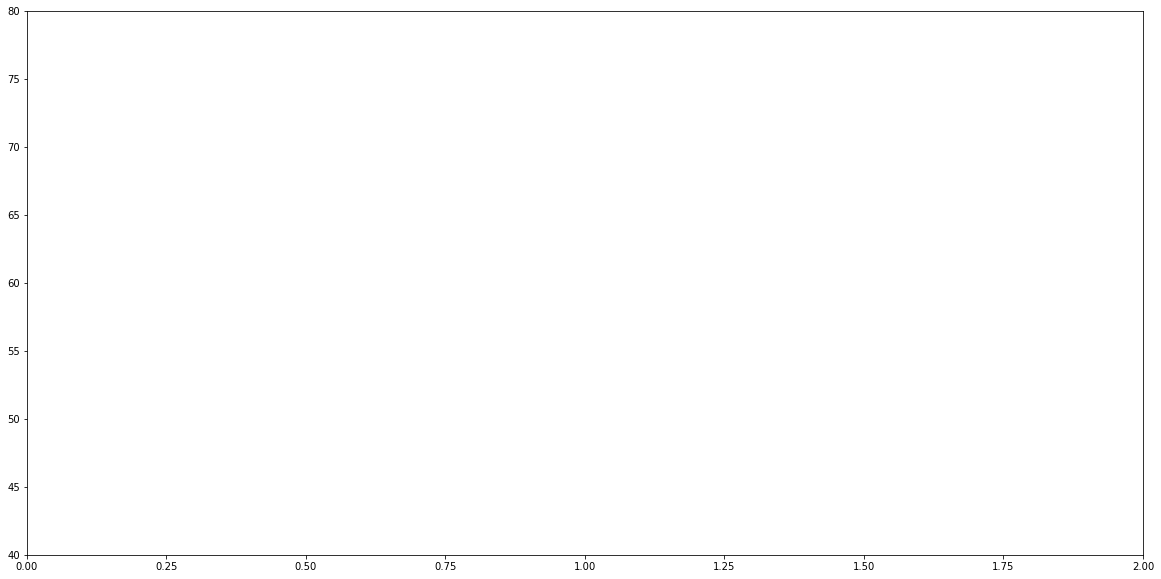

In [28]:
ns  = [3, 5, 7, 9]
clr = ['r', 'y', 'g', 'b']


plainnet_dfs = [pd.read_csv(f'plainnet{6*n+2}.csv') for n in ns]
fig = plt.figure(figsize=(20, 10))
plt.axis([0, 2, 40, 80])


for i in range(len(ns)):
    plt.plot(plainnet_dfs[i]['epoch'], plainnet_dfs[i]['train_err']*100, f'{clr[i]}--',
             label=f'plain-{6*ns[i]+2} train')
    plt.plot(plainnet_dfs[i]['epoch'], plainnet_dfs[i]['test_err']*100, f'{clr[i]}',
             label=f'plain-{6*ns[i]+2} test')

plt.title('Comparison of four plain convolutional networks with 20, 32, 44 and 56 layers.')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('error (%)')
plt.axhline(70, color='black', alpha=0.5, dashes=(10., 10.))
plt.axhline(60, color='black', alpha=0.5, dashes=(10., 10.));
plt.axhline(50, color='black', alpha=0.5, dashes=(10., 10.));

In [28]:
bests = [df[df['test_err'] == df['test_err'].min()].iloc[0] for df in plainnet_dfs]
bests_df= pd.concat(bests, axis=1).T
bests_df['model'] = [f'PlainNet{6*n+2}' for n in ns]
display(bests_df[['model', 'test_err']])

model  test_err
2  PlainNet20    0.4221
2  PlainNet32    0.5710
1  PlainNet44    0.7038
2  PlainNet56    0.7094

### Resnet

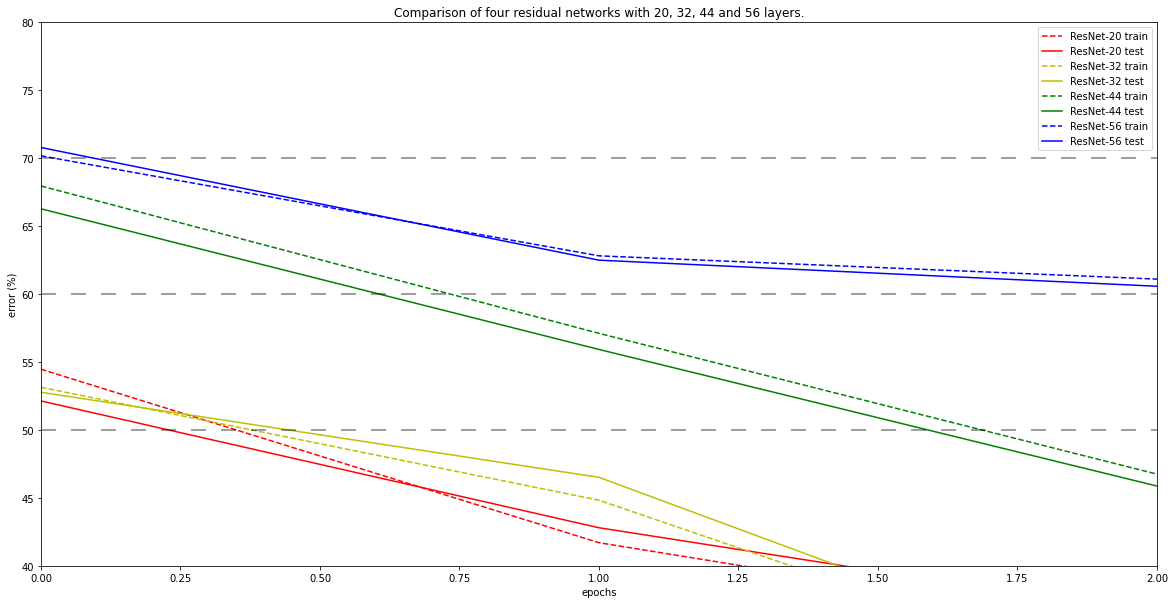

In [29]:
ns  = [3, 5, 7, 9]
clr = ['r', 'y', 'g', 'b']

resnet_dfs = [pd.read_csv(f'resnet{6*n+2}.csv') for n in ns]
fig = plt.figure(figsize=(20, 10))
plt.axis([0, 2, 40, 80])


for i in range(len(ns)):
    plt.plot(resnet_dfs[i]['epoch'], resnet_dfs[i]['train_err']*100, f'{clr[i]}--',
             label=f'ResNet-{6*ns[i]+2} train')
    plt.plot(resnet_dfs[i]['epoch'], resnet_dfs[i]['test_err']*100, f'{clr[i]}',
             label=f'ResNet-{6*ns[i]+2} test')

plt.title('Comparison of four residual networks with 20, 32, 44 and 56 layers.')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('error (%)')
plt.axhline(70, color='black', alpha=0.5, dashes=(10., 10.))
plt.axhline(60, color='black', alpha=0.5, dashes=(10., 10.));
plt.axhline(50, color='black', alpha=0.5, dashes=(10., 10.));

In [31]:
bests = [df[df['test_err'] == df['test_err'].min()].iloc[0] for df in resnet_dfs]
bests_df= pd.concat(bests, axis=1).T
bests_df['model'] = [f'ResNet{6*n+2}' for n in ns]
display(bests_df[['model', 'test_err']])


model  test_err
17  ResNet20    0.1709
19  ResNet32    0.1514
19  ResNet44    0.1857
19  ResNet56    0.2503

## Side-by-side plot

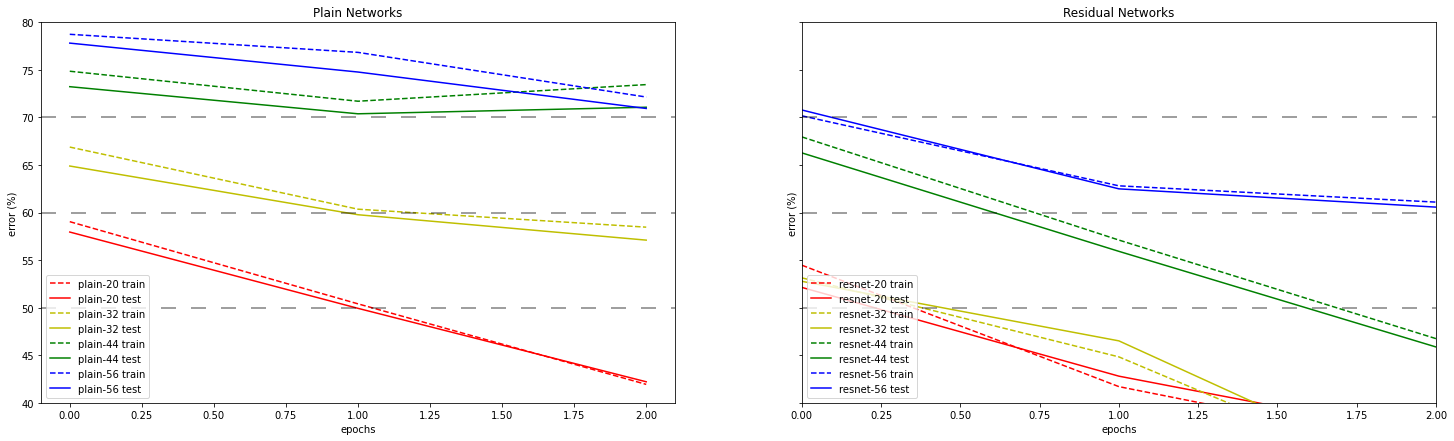

In [33]:
ns  = [3, 5, 7, 9]
clr = ['r', 'y', 'g', 'b']


f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(25, 7))

plainnet_dfs = [pd.read_csv(f'plainnet{6*n+2}.csv') for n in ns]
resnet_dfs = [pd.read_csv(f'resnet{6*n+2}.csv') for n in ns]

def plot_results(dfs, ax, title, label, color=None):
    plt.axis([0, 2, 40, 80])
    
    for i in range(len(ns)):
        ax.plot(dfs[i]['epoch'], dfs[i]['train_err']*100, f'{color if color else clr[i]}--',
                 label=f'{label}-{6*ns[i]+2} train')
        ax.plot(dfs[i]['epoch'], dfs[i]['test_err']*100, f'{color if color else clr[i]}',
                 label=f'{label}-{6*ns[i]+2} test')
    
    ax.set_title(title)
    ax.legend(loc='lower left')
    ax.set_xlabel('epochs')
    ax.set_ylabel('error (%)')
    ax.axhline(70, color='black', alpha=0.5, dashes=(10., 10.))
    ax.axhline(60, color='black', alpha=0.5, dashes=(10., 10.));
    ax.axhline(50, color='black', alpha=0.5, dashes=(10., 10.));
    
plot_results(plainnet_dfs, ax1, 'Plain Networks', 'plain')
plot_results(resnet_dfs, ax2, 'Residual Networks', 'resnet')